In [1]:
import os
import torch
import argparse

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from model.unet3d import UnetModel
from dataloaders import dataloader

In [2]:
DATADIR = 'data'
RESULTDIR = 'result'
BATCHSIZE = 8
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 100
THRESHOLD = 0.5

In [3]:
os.makedirs(RESULTDIR, exist_ok=True)

In [4]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [5]:
## Call model
m = UnetModel(in_channels=1, out_channels=1).to(device)
for name, p in m.named_parameters():
    print(name)
## Call optimizer
opt = Adam(params=m.parameters(), lr=LEARNING_RATE)
## Call dataloaders
train_dataloader, valid_dataloader = dataloader(root=DATADIR, batch_size=BATCHSIZE)
## Define Loss function
criterion = nn.BCELoss(reduction='mean')

encoder.module_dict.conv_0_0.conv3d.weight
encoder.module_dict.conv_0_0.conv3d.bias
encoder.module_dict.conv_0_1.conv3d.weight
encoder.module_dict.conv_0_1.conv3d.bias
encoder.module_dict.conv_1_0.conv3d.weight
encoder.module_dict.conv_1_0.conv3d.bias
encoder.module_dict.conv_1_1.conv3d.weight
encoder.module_dict.conv_1_1.conv3d.bias
encoder.module_dict.conv_2_0.conv3d.weight
encoder.module_dict.conv_2_0.conv3d.bias
encoder.module_dict.conv_2_1.conv3d.weight
encoder.module_dict.conv_2_1.conv3d.bias
encoder.module_dict.conv_3_0.conv3d.weight
encoder.module_dict.conv_3_0.conv3d.bias
encoder.module_dict.conv_3_1.conv3d.weight
encoder.module_dict.conv_3_1.conv3d.bias
decoder.module_dict.deconv_2.conv3d_transpose.weight
decoder.module_dict.deconv_2.conv3d_transpose.bias
decoder.module_dict.conv_2_0.conv3d.weight
decoder.module_dict.conv_2_0.conv3d.bias
decoder.module_dict.conv_2_1.conv3d.weight
decoder.module_dict.conv_2_1.conv3d.bias
decoder.module_dict.deconv_1.conv3d_transpose.weight
dec

## Training

In [6]:
bestStats = -np.float('inf')

for epoch in range(NUM_EPOCHS):
    epochLoss = 0
    trainStats = 0
    m.train()
    print('Epoch {}'.format(epoch+1))
    for i, pack in enumerate(train_dataloader):
        Input = pack['seismic'].to(device).float()
        Label = pack['fault'].to(device).float()
            
        Output = m(Input) # [batchsize, 1, 64, 64, 64]
                
        Output = torch.sigmoid(Output)
        
        opt.zero_grad()
        loss = criterion(Output, Label)
        loss.backward()
        opt.step()
        
        epochLoss += loss.item()
        real_y = Label.cpu().data.numpy()
        pred_y = (Output.cpu().data.numpy() > THRESHOLD)
        
        ## Do XNOR
        intersects = ~np.logical_xor(real_y, pred_y)        
        intersects = np.sum(intersects)
        total = intersects / (BATCHSIZE*(64*64*64))
    
        trainStats += total
    
    print('\tLoss {} Accuracy {}'.format(epochLoss/(i+1), trainStats/(i+1)))
    
    ValidStats = 0
    ValidLoss = 0

    ## Do validate
    m.eval()
    for j, pack in enumerate(valid_dataloader):
        Input = pack['seismic'].to(device)
        Label = pack['fault'].to(device)
        
        with torch.no_grad():
            Output = m(Input) # [1, 1, 64, 64, 64]
            Output = torch.sigmoid(Output)
           
            loss = criterion(Output, Label)
            
            real_y = Label.cpu().data.numpy()
            print(torch.max(Output), torch.min(Output))
            pred_y = (Output.cpu().data.numpy() > THRESHOLD)
            
            ## Do XNOR
            intersects = ~np.logical_xor(real_y, pred_y)        
            intersects = np.sum(intersects)
            total = intersects / (BATCHSIZE*(64*64*64))
            ValidStats += total
            ValidLoss += loss.item()
            print(j, total)
            
    print('\tValid Loss {} Accuracy {}'.format(ValidLoss/(j+1), ValidStats/(j+1)))  
    if bestStats < ValidLoss:
          bestStats = ValidLoss
          ## model save
          torch.save({'model_state_dict': m.state_dict(),
                      'opt_state_dict': opt.state_dict(),
                      'epoch': epoch+1}, os.path.join(RESULTDIR, 'facies.pth'))
          

Epoch 1
	Loss 0.33703509493479655 Accuracy 0.9216409259372287
tensor(0.4590, device='cuda:0') tensor(0.0015, device='cuda:0')
0 0.9252333641052246
tensor(0.4608, device='cuda:0') tensor(0.0018, device='cuda:0')
1 0.9494743347167969
tensor(0.4550, device='cuda:0') tensor(0.0006, device='cuda:0')
2 0.8934416770935059
tensor(0.4507, device='cuda:0') tensor(0.0018, device='cuda:0')
3 0.9123601913452148
tensor(0.4584, device='cuda:0') tensor(0.0005, device='cuda:0')
4 0.9424490928649902
tensor(0.4644, device='cuda:0') tensor(0.0022, device='cuda:0')
5 0.9551687240600586
tensor(0.4582, device='cuda:0') tensor(0.0007, device='cuda:0')
6 0.914057731628418
tensor(0.4552, device='cuda:0') tensor(0.0030, device='cuda:0')
7 0.9041614532470703
tensor(0.4593, device='cuda:0') tensor(0.0031, device='cuda:0')
8 0.924750804901123
tensor(0.4600, device='cuda:0') tensor(0.0019, device='cuda:0')
9 0.9145417213439941
tensor(0.4580, device='cuda:0') tensor(0.0026, device='cuda:0')
10 0.9103035926818848
tens

tensor(0.3639, device='cuda:0') tensor(0.0095, device='cuda:0')
10 0.9103035926818848
tensor(0.3455, device='cuda:0') tensor(0.0171, device='cuda:0')
11 0.9401645660400391
tensor(0.3541, device='cuda:0') tensor(0.0032, device='cuda:0')
12 0.9384689331054688
tensor(0.3553, device='cuda:0') tensor(0.0101, device='cuda:0')
13 0.9336185455322266
tensor(0.3436, device='cuda:0') tensor(0.0149, device='cuda:0')
14 0.924689769744873
tensor(0.3574, device='cuda:0') tensor(0.0086, device='cuda:0')
15 0.918241024017334
tensor(0.3622, device='cuda:0') tensor(0.0141, device='cuda:0')
16 0.9365754127502441
tensor(0.3655, device='cuda:0') tensor(0.0096, device='cuda:0')
17 0.9382047653198242
tensor(0.3390, device='cuda:0') tensor(0.0110, device='cuda:0')
18 0.9422740936279297
tensor(0.3586, device='cuda:0') tensor(0.0138, device='cuda:0')
19 0.935945987701416
	Valid Loss 0.24059275537729263 Accuracy 0.9277062892913819
Epoch 6
	Loss 0.24755835958889552 Accuracy 0.9216504096984863
tensor(0.3307, device

	Loss 0.2327583772795541 Accuracy 0.9218471996367924
tensor(0.5260, device='cuda:0') tensor(0.0021, device='cuda:0')
0 0.9252357482910156
tensor(0.6196, device='cuda:0') tensor(0.0005, device='cuda:0')
1 0.9527058601379395
tensor(0.5507, device='cuda:0') tensor(5.6777e-05, device='cuda:0')
2 0.8937501907348633
tensor(0.6021, device='cuda:0') tensor(0.0005, device='cuda:0')
3 0.9136028289794922
tensor(0.5545, device='cuda:0') tensor(0.0009, device='cuda:0')
4 0.9424452781677246
tensor(0.6358, device='cuda:0') tensor(0.0002, device='cuda:0')
5 0.960446834564209
tensor(0.5499, device='cuda:0') tensor(0.0006, device='cuda:0')
6 0.9140629768371582
tensor(0.5656, device='cuda:0') tensor(0.0008, device='cuda:0')
7 0.9042291641235352
tensor(0.6130, device='cuda:0') tensor(0.0003, device='cuda:0')
8 0.9325213432312012
tensor(0.6157, device='cuda:0') tensor(0.0008, device='cuda:0')
9 0.9160714149475098
tensor(0.5638, device='cuda:0') tensor(0.0008, device='cuda:0')
10 0.9103794097900391
tensor(0

tensor(0.6948, device='cuda:0') tensor(0.0025, device='cuda:0')
10 0.9113264083862305
tensor(0.6799, device='cuda:0') tensor(0.0032, device='cuda:0')
11 0.9402709007263184
tensor(0.7896, device='cuda:0') tensor(0.0002, device='cuda:0')
12 0.950617790222168
tensor(0.6610, device='cuda:0') tensor(0.0022, device='cuda:0')
13 0.9343051910400391
tensor(0.7187, device='cuda:0') tensor(0.0017, device='cuda:0')
14 0.9264721870422363
tensor(0.7984, device='cuda:0') tensor(0.0013, device='cuda:0')
15 0.9277000427246094
tensor(0.8066, device='cuda:0') tensor(0.0026, device='cuda:0')
16 0.9409971237182617
tensor(0.8401, device='cuda:0') tensor(0.0007, device='cuda:0')
17 0.9448404312133789
tensor(0.7776, device='cuda:0') tensor(0.0018, device='cuda:0')
18 0.952115535736084
tensor(0.7678, device='cuda:0') tensor(0.0018, device='cuda:0')
19 0.9436025619506836
	Valid Loss 0.17371336705982685 Accuracy 0.9353747367858887
Epoch 15
	Loss 0.22170925258644045 Accuracy 0.9234527027796186
tensor(0.7511, devi

	Loss 0.2163497026241015 Accuracy 0.9244351008581737
tensor(0.7915, device='cuda:0') tensor(0.0054, device='cuda:0')
0 0.9373979568481445
tensor(0.8710, device='cuda:0') tensor(0.0034, device='cuda:0')
1 0.964348316192627
tensor(0.8979, device='cuda:0') tensor(0.0006, device='cuda:0')
2 0.9177703857421875
tensor(0.8895, device='cuda:0') tensor(0.0038, device='cuda:0')
3 0.930302619934082
tensor(0.7400, device='cuda:0') tensor(0.0025, device='cuda:0')
4 0.9427156448364258
tensor(0.9444, device='cuda:0') tensor(0.0015, device='cuda:0')
5 0.9738492965698242
tensor(0.7129, device='cuda:0') tensor(0.0017, device='cuda:0')
6 0.9156641960144043
tensor(0.8559, device='cuda:0') tensor(0.0022, device='cuda:0')
7 0.9142894744873047
tensor(0.9087, device='cuda:0') tensor(0.0035, device='cuda:0')
8 0.9576077461242676
tensor(0.8795, device='cuda:0') tensor(0.0029, device='cuda:0')
9 0.9282808303833008
tensor(0.7342, device='cuda:0') tensor(0.0034, device='cuda:0')
10 0.9128637313842773
tensor(0.7155

tensor(0.6655, device='cuda:0') tensor(0.0047, device='cuda:0')
10 0.9110236167907715
tensor(0.6104, device='cuda:0') tensor(0.0040, device='cuda:0')
11 0.9404797554016113
tensor(0.8659, device='cuda:0') tensor(0.0011, device='cuda:0')
12 0.9576592445373535
tensor(0.6230, device='cuda:0') tensor(0.0040, device='cuda:0')
13 0.9339065551757812
tensor(0.7823, device='cuda:0') tensor(0.0037, device='cuda:0')
14 0.9285192489624023
tensor(0.7748, device='cuda:0') tensor(0.0027, device='cuda:0')
15 0.9258975982666016
tensor(0.7855, device='cuda:0') tensor(0.0039, device='cuda:0')
16 0.9400734901428223
tensor(0.7878, device='cuda:0') tensor(0.0037, device='cuda:0')
17 0.9472107887268066
tensor(0.7621, device='cuda:0') tensor(0.0032, device='cuda:0')
18 0.9525017738342285
tensor(0.8278, device='cuda:0') tensor(0.0025, device='cuda:0')
19 0.9446072578430176
	Valid Loss 0.15638405866920949 Accuracy 0.9375739574432373
Epoch 24
	Loss 0.2105731601043353 Accuracy 0.9252569107782274
tensor(0.7977, dev

	Loss 0.21111805382229032 Accuracy 0.9253085832747202
tensor(0.8025, device='cuda:0') tensor(0.0067, device='cuda:0')
0 0.9445276260375977
tensor(0.8631, device='cuda:0') tensor(0.0020, device='cuda:0')
1 0.961036205291748
tensor(0.8977, device='cuda:0') tensor(0.0021, device='cuda:0')
2 0.9304356575012207
tensor(0.8729, device='cuda:0') tensor(0.0042, device='cuda:0')
3 0.9333963394165039
tensor(0.6821, device='cuda:0') tensor(0.0038, device='cuda:0')
4 0.9423866271972656
tensor(0.9235, device='cuda:0') tensor(0.0017, device='cuda:0')
5 0.9748406410217285
tensor(0.6228, device='cuda:0') tensor(0.0051, device='cuda:0')
6 0.9145183563232422
tensor(0.8711, device='cuda:0') tensor(0.0032, device='cuda:0')
7 0.9192533493041992
tensor(0.9137, device='cuda:0') tensor(0.0030, device='cuda:0')
8 0.9596395492553711
tensor(0.8256, device='cuda:0') tensor(0.0053, device='cuda:0')
9 0.927943229675293
tensor(0.7256, device='cuda:0') tensor(0.0065, device='cuda:0')
10 0.9117989540100098
tensor(0.702

tensor(0.7010, device='cuda:0') tensor(0.0014, device='cuda:0')
10 0.9132304191589355
tensor(0.6376, device='cuda:0') tensor(0.0008, device='cuda:0')
11 0.9415206909179688
tensor(0.9165, device='cuda:0') tensor(0.0001, device='cuda:0')
12 0.9644484519958496
tensor(0.7155, device='cuda:0') tensor(0.0006, device='cuda:0')
13 0.9350848197937012
tensor(0.8294, device='cuda:0') tensor(0.0010, device='cuda:0')
14 0.9338631629943848
tensor(0.8627, device='cuda:0') tensor(0.0005, device='cuda:0')
15 0.936798095703125
tensor(0.8648, device='cuda:0') tensor(0.0018, device='cuda:0')
16 0.944514274597168
tensor(0.8664, device='cuda:0') tensor(0.0009, device='cuda:0')
17 0.9534387588500977
tensor(0.8545, device='cuda:0') tensor(0.0003, device='cuda:0')
18 0.9608559608459473
tensor(0.8770, device='cuda:0') tensor(0.0002, device='cuda:0')
19 0.952733039855957
	Valid Loss 0.1434770729392767 Accuracy 0.9430909633636475
Epoch 33
	Loss 0.2008662185971699 Accuracy 0.9261220750354585
tensor(0.8070, device=

tensor(0.9382, device='cuda:0') tensor(1.4620e-05, device='cuda:0')
19 0.9562654495239258
	Valid Loss 0.13941859267652035 Accuracy 0.944450569152832
Epoch 37
	Loss 0.19303695360819498 Accuracy 0.9270299351404584
tensor(0.9056, device='cuda:0') tensor(3.7363e-07, device='cuda:0')
0 0.9517817497253418
tensor(0.8916, device='cuda:0') tensor(2.8743e-07, device='cuda:0')
1 0.9660000801086426
tensor(0.9360, device='cuda:0') tensor(4.9473e-09, device='cuda:0')
2 0.9347186088562012
tensor(0.9283, device='cuda:0') tensor(1.3961e-07, device='cuda:0')
3 0.9392781257629395
tensor(0.7153, device='cuda:0') tensor(4.5487e-06, device='cuda:0')
4 0.9425621032714844
tensor(0.9457, device='cuda:0') tensor(1.8775e-09, device='cuda:0')
5 0.9749083518981934
tensor(0.7265, device='cuda:0') tensor(1.8774e-05, device='cuda:0')
6 0.9148955345153809
tensor(0.9242, device='cuda:0') tensor(4.5497e-06, device='cuda:0')
7 0.9232344627380371
tensor(0.9492, device='cuda:0') tensor(1.8147e-06, device='cuda:0')
8 0.9631

tensor(0.9545, device='cuda:0') tensor(7.6011e-08, device='cuda:0')
5 0.9756507873535156
tensor(0.7802, device='cuda:0') tensor(5.7083e-05, device='cuda:0')
6 0.9130496978759766
tensor(0.9136, device='cuda:0') tensor(8.1786e-05, device='cuda:0')
7 0.9242229461669922
tensor(0.9312, device='cuda:0') tensor(1.2420e-05, device='cuda:0')
8 0.9658188819885254
tensor(0.8680, device='cuda:0') tensor(6.3077e-05, device='cuda:0')
9 0.9376635551452637
tensor(0.7852, device='cuda:0') tensor(4.5911e-05, device='cuda:0')
10 0.9113883972167969
tensor(0.8604, device='cuda:0') tensor(9.5970e-06, device='cuda:0')
11 0.9384660720825195
tensor(0.9448, device='cuda:0') tensor(1.3390e-06, device='cuda:0')
12 0.9737586975097656
tensor(0.8528, device='cuda:0') tensor(8.2686e-06, device='cuda:0')
13 0.9342522621154785
tensor(0.8933, device='cuda:0') tensor(1.0213e-05, device='cuda:0')
14 0.9392051696777344
tensor(0.8558, device='cuda:0') tensor(1.7312e-05, device='cuda:0')
15 0.9381022453308105
tensor(0.8598, 

tensor(0.9446, device='cuda:0') tensor(4.1076e-07, device='cuda:0')
12 0.975837230682373
tensor(0.8531, device='cuda:0') tensor(1.0891e-06, device='cuda:0')
13 0.9313721656799316
tensor(0.8470, device='cuda:0') tensor(5.9930e-06, device='cuda:0')
14 0.937781810760498
tensor(0.8522, device='cuda:0') tensor(1.8757e-05, device='cuda:0')
15 0.9398784637451172
tensor(0.8619, device='cuda:0') tensor(7.1370e-05, device='cuda:0')
16 0.9453825950622559
tensor(0.9148, device='cuda:0') tensor(4.3020e-07, device='cuda:0')
17 0.9615054130554199
tensor(0.8846, device='cuda:0') tensor(3.3274e-08, device='cuda:0')
18 0.962590217590332
tensor(0.9251, device='cuda:0') tensor(1.8916e-07, device='cuda:0')
19 0.9581103324890137
	Valid Loss 0.14110195264220238 Accuracy 0.9459911823272705
Epoch 46
	Loss 0.17432007501049648 Accuracy 0.9288099304078117
tensor(0.9550, device='cuda:0') tensor(3.9854e-07, device='cuda:0')
0 0.9598503112792969
tensor(0.8947, device='cuda:0') tensor(5.2569e-06, device='cuda:0')
1 0

tensor(0.9732, device='cuda:0') tensor(2.0731e-07, device='cuda:0')
19 0.9586901664733887
	Valid Loss 0.13384014181792736 Accuracy 0.9469369888305664
Epoch 50
	Loss 0.16964654872814813 Accuracy 0.9298729820856972
tensor(0.9510, device='cuda:0') tensor(1.6871e-08, device='cuda:0')
0 0.9580893516540527
tensor(0.9107, device='cuda:0') tensor(1.7133e-07, device='cuda:0')
1 0.9734077453613281
tensor(0.9830, device='cuda:0') tensor(3.0304e-09, device='cuda:0')
2 0.9428057670593262
tensor(0.9587, device='cuda:0') tensor(5.2412e-07, device='cuda:0')
3 0.9441108703613281
tensor(0.8607, device='cuda:0') tensor(3.5010e-06, device='cuda:0')
4 0.9401102066040039
tensor(0.9807, device='cuda:0') tensor(1.4269e-09, device='cuda:0')
5 0.9774012565612793
tensor(0.8880, device='cuda:0') tensor(6.1801e-06, device='cuda:0')
6 0.9140706062316895
tensor(0.9393, device='cuda:0') tensor(2.0186e-07, device='cuda:0')
7 0.9279012680053711
tensor(0.9480, device='cuda:0') tensor(3.2061e-07, device='cuda:0')
8 0.969

tensor(0.8947, device='cuda:0') tensor(4.8597e-06, device='cuda:0')
4 0.9410433769226074
tensor(0.9856, device='cuda:0') tensor(1.0840e-11, device='cuda:0')
5 0.9772152900695801
tensor(0.8922, device='cuda:0') tensor(4.3408e-06, device='cuda:0')
6 0.9178037643432617
tensor(0.9355, device='cuda:0') tensor(1.8868e-07, device='cuda:0')
7 0.9299564361572266
tensor(0.9576, device='cuda:0') tensor(1.9577e-07, device='cuda:0')
8 0.9703130722045898
tensor(0.9528, device='cuda:0') tensor(6.1360e-07, device='cuda:0')
9 0.9442267417907715
tensor(0.8578, device='cuda:0') tensor(2.0913e-07, device='cuda:0')
10 0.910529613494873
tensor(0.9457, device='cuda:0') tensor(1.1345e-07, device='cuda:0')
11 0.9463562965393066
tensor(0.9762, device='cuda:0') tensor(8.2355e-08, device='cuda:0')
12 0.9788017272949219
tensor(0.9221, device='cuda:0') tensor(9.2148e-08, device='cuda:0')
13 0.9313287734985352
tensor(0.9553, device='cuda:0') tensor(4.1594e-08, device='cuda:0')
14 0.9365038871765137
tensor(0.9167, de

tensor(0.9737, device='cuda:0') tensor(1.5736e-08, device='cuda:0')
11 0.9421768188476562
tensor(0.9745, device='cuda:0') tensor(9.3720e-09, device='cuda:0')
12 0.9767484664916992
tensor(0.9490, device='cuda:0') tensor(1.9628e-09, device='cuda:0')
13 0.9292774200439453
tensor(0.9862, device='cuda:0') tensor(5.8519e-11, device='cuda:0')
14 0.9364843368530273
tensor(0.8961, device='cuda:0') tensor(8.2717e-08, device='cuda:0')
15 0.9429488182067871
tensor(0.8809, device='cuda:0') tensor(6.5734e-05, device='cuda:0')
16 0.9448623657226562
tensor(0.9752, device='cuda:0') tensor(2.1289e-11, device='cuda:0')
17 0.9625134468078613
tensor(0.9501, device='cuda:0') tensor(4.1426e-10, device='cuda:0')
18 0.9578561782836914
tensor(0.9265, device='cuda:0') tensor(1.9649e-07, device='cuda:0')
19 0.9558444023132324
	Valid Loss 0.13762645050883293 Accuracy 0.9460983276367188
Epoch 59
	Loss 0.15151948706498222 Accuracy 0.933780692872547
tensor(0.9933, device='cuda:0') tensor(3.1027e-15, device='cuda:0')


tensor(0.9791, device='cuda:0') tensor(9.1765e-14, device='cuda:0')
18 0.9537949562072754
tensor(0.9680, device='cuda:0') tensor(6.5597e-07, device='cuda:0')
19 0.9571003913879395
	Valid Loss 0.14146499745547772 Accuracy 0.9445926427841187
Epoch 63
	Loss 0.1421078047345555 Accuracy 0.9370307846674844
tensor(0.9984, device='cuda:0') tensor(9.2957e-24, device='cuda:0')
0 0.964937686920166
tensor(0.9805, device='cuda:0') tensor(4.3074e-15, device='cuda:0')
1 0.970618724822998
tensor(0.9991, device='cuda:0') tensor(7.7842e-21, device='cuda:0')
2 0.942009449005127
tensor(0.9961, device='cuda:0') tensor(1.0468e-14, device='cuda:0')
3 0.9505915641784668
tensor(0.9819, device='cuda:0') tensor(1.7559e-09, device='cuda:0')
4 0.9380941390991211
tensor(0.9958, device='cuda:0') tensor(6.2263e-20, device='cuda:0')
5 0.9761991500854492
tensor(0.9837, device='cuda:0') tensor(4.2026e-09, device='cuda:0')
6 0.9073901176452637
tensor(0.9947, device='cuda:0') tensor(4.9969e-21, device='cuda:0')
7 0.935353

tensor(0.9886, device='cuda:0') tensor(1.0753e-09, device='cuda:0')
3 0.9477972984313965
tensor(0.9135, device='cuda:0') tensor(6.5866e-08, device='cuda:0')
4 0.9496030807495117
tensor(0.9885, device='cuda:0') tensor(3.1156e-16, device='cuda:0')
5 0.9752864837646484
tensor(0.9526, device='cuda:0') tensor(8.5265e-07, device='cuda:0')
6 0.9275598526000977
tensor(0.9869, device='cuda:0') tensor(5.8918e-11, device='cuda:0')
7 0.9326791763305664
tensor(0.9980, device='cuda:0') tensor(2.3780e-10, device='cuda:0')
8 0.968407154083252
tensor(0.9949, device='cuda:0') tensor(4.3479e-08, device='cuda:0')
9 0.9493942260742188
tensor(0.9368, device='cuda:0') tensor(4.9336e-07, device='cuda:0')
10 0.906928539276123
tensor(0.9861, device='cuda:0') tensor(9.2357e-09, device='cuda:0')
11 0.9626150131225586
tensor(0.9956, device='cuda:0') tensor(2.5179e-09, device='cuda:0')
12 0.9813027381896973
tensor(0.9533, device='cuda:0') tensor(1.2009e-09, device='cuda:0')
13 0.9551348686218262
tensor(0.9991, devi

tensor(0.9824, device='cuda:0') tensor(2.0074e-08, device='cuda:0')
10 0.8990092277526855
tensor(0.9944, device='cuda:0') tensor(3.4301e-12, device='cuda:0')
11 0.9520878791809082
tensor(0.9996, device='cuda:0') tensor(9.2654e-13, device='cuda:0')
12 0.9749250411987305
tensor(0.9982, device='cuda:0') tensor(5.8938e-14, device='cuda:0')
13 0.9196772575378418
tensor(0.9997, device='cuda:0') tensor(1.4512e-15, device='cuda:0')
14 0.9406819343566895
tensor(0.9968, device='cuda:0') tensor(2.1645e-10, device='cuda:0')
15 0.9456009864807129
tensor(0.9801, device='cuda:0') tensor(7.2032e-09, device='cuda:0')
16 0.9291105270385742
tensor(0.9996, device='cuda:0') tensor(2.3867e-14, device='cuda:0')
17 0.9616522789001465
tensor(0.9995, device='cuda:0') tensor(2.1180e-20, device='cuda:0')
18 0.933713436126709
tensor(0.9969, device='cuda:0') tensor(4.1900e-11, device='cuda:0')
19 0.9380650520324707
	Valid Loss 0.15738376304507257 Accuracy 0.9431193351745606
Epoch 72
	Loss 0.12088796295343883 Accura

tensor(0.9988, device='cuda:0') tensor(1.4400e-13, device='cuda:0')
17 0.9623970985412598
tensor(0.9998, device='cuda:0') tensor(5.5554e-19, device='cuda:0')
18 0.9726424217224121
tensor(0.9989, device='cuda:0') tensor(5.3293e-10, device='cuda:0')
19 0.9389829635620117
	Valid Loss 0.1485231850296259 Accuracy 0.9464797973632812
Epoch 76
	Loss 0.11120961050665568 Accuracy 0.9471923737298875
tensor(0.9997, device='cuda:0') tensor(1.5646e-18, device='cuda:0')
0 0.955812931060791
tensor(0.9908, device='cuda:0') tensor(9.2570e-15, device='cuda:0')
1 0.9687213897705078
tensor(0.9998, device='cuda:0') tensor(5.5060e-19, device='cuda:0')
2 0.9140634536743164
tensor(0.9991, device='cuda:0') tensor(1.2993e-11, device='cuda:0')
3 0.947899341583252
tensor(0.9522, device='cuda:0') tensor(4.5569e-08, device='cuda:0')
4 0.9444231986999512
tensor(0.9968, device='cuda:0') tensor(1.5549e-19, device='cuda:0')
5 0.9689760208129883
tensor(0.9682, device='cuda:0') tensor(3.5374e-07, device='cuda:0')
6 0.9124

tensor(0.9998, device='cuda:0') tensor(4.3234e-19, device='cuda:0')
2 0.9084887504577637
tensor(0.9996, device='cuda:0') tensor(5.7778e-12, device='cuda:0')
3 0.9434294700622559
tensor(0.9869, device='cuda:0') tensor(8.7007e-12, device='cuda:0')
4 0.9396953582763672
tensor(0.9979, device='cuda:0') tensor(2.5240e-18, device='cuda:0')
5 0.9654984474182129
tensor(0.9948, device='cuda:0') tensor(3.3184e-10, device='cuda:0')
6 0.9089622497558594
tensor(0.9995, device='cuda:0') tensor(6.8307e-17, device='cuda:0')
7 0.9336295127868652
tensor(0.9999, device='cuda:0') tensor(2.5053e-13, device='cuda:0')
8 0.9705696105957031
tensor(0.9998, device='cuda:0') tensor(2.1549e-10, device='cuda:0')
9 0.9485039710998535
tensor(0.9912, device='cuda:0') tensor(4.1051e-09, device='cuda:0')
10 0.8777518272399902
tensor(0.9988, device='cuda:0') tensor(1.0190e-14, device='cuda:0')
11 0.9579014778137207
tensor(0.9996, device='cuda:0') tensor(4.9355e-14, device='cuda:0')
12 0.9664888381958008
tensor(0.9959, dev

tensor(0.9991, device='cuda:0') tensor(6.3244e-12, device='cuda:0')
9 0.9293737411499023
tensor(0.9937, device='cuda:0') tensor(6.7718e-10, device='cuda:0')
10 0.881568431854248
tensor(0.9986, device='cuda:0') tensor(1.5992e-12, device='cuda:0')
11 0.9458231925964355
tensor(0.9996, device='cuda:0') tensor(1.4158e-14, device='cuda:0')
12 0.9763007164001465
tensor(0.9986, device='cuda:0') tensor(4.8338e-15, device='cuda:0')
13 0.9139876365661621
tensor(0.9998, device='cuda:0') tensor(8.8103e-15, device='cuda:0')
14 0.92388916015625
tensor(0.9990, device='cuda:0') tensor(3.2352e-12, device='cuda:0')
15 0.9384956359863281
tensor(0.9976, device='cuda:0') tensor(6.7213e-11, device='cuda:0')
16 0.9245905876159668
tensor(0.9996, device='cuda:0') tensor(8.1087e-16, device='cuda:0')
17 0.9609475135803223
tensor(0.9998, device='cuda:0') tensor(1.5083e-19, device='cuda:0')
18 0.9238176345825195
tensor(0.9996, device='cuda:0') tensor(4.6058e-17, device='cuda:0')
19 0.9466037750244141
	Valid Loss 0.

tensor(0.9966, device='cuda:0') tensor(1.1010e-10, device='cuda:0')
16 0.9315390586853027
tensor(0.9996, device='cuda:0') tensor(6.1847e-15, device='cuda:0')
17 0.9648733139038086
tensor(0.9987, device='cuda:0') tensor(5.4141e-20, device='cuda:0')
18 0.9337396621704102
tensor(0.9997, device='cuda:0') tensor(9.8036e-16, device='cuda:0')
19 0.9575872421264648
	Valid Loss 0.21165360808372496 Accuracy 0.9422481775283813
Epoch 89
	Loss 0.07716348223269932 Accuracy 0.9601339461311461
tensor(0.9999, device='cuda:0') tensor(3.9015e-18, device='cuda:0')
0 0.9512243270874023
tensor(0.9986, device='cuda:0') tensor(8.4186e-17, device='cuda:0')
1 0.952153205871582
tensor(0.9998, device='cuda:0') tensor(7.5483e-19, device='cuda:0')
2 0.8963942527770996
tensor(0.9998, device='cuda:0') tensor(6.2032e-12, device='cuda:0')
3 0.9455265998840332
tensor(0.9910, device='cuda:0') tensor(2.2675e-12, device='cuda:0')
4 0.9230356216430664
tensor(0.9993, device='cuda:0') tensor(1.6259e-21, device='cuda:0')
5 0.9

tensor(0.9995, device='cuda:0') tensor(5.5389e-21, device='cuda:0')
1 0.949742317199707
tensor(0.9999, device='cuda:0') tensor(2.4479e-24, device='cuda:0')
2 0.9066314697265625
tensor(0.9998, device='cuda:0') tensor(8.4490e-13, device='cuda:0')
3 0.9418702125549316
tensor(0.9963, device='cuda:0') tensor(6.0761e-16, device='cuda:0')
4 0.9208006858825684
tensor(0.9995, device='cuda:0') tensor(7.8154e-24, device='cuda:0')
5 0.9699292182922363
tensor(0.9980, device='cuda:0') tensor(1.9751e-18, device='cuda:0')
6 0.881866455078125
tensor(0.9998, device='cuda:0') tensor(5.4233e-15, device='cuda:0')
7 0.9243879318237305
tensor(0.9999, device='cuda:0') tensor(3.2244e-16, device='cuda:0')
8 0.9672145843505859
tensor(0.9993, device='cuda:0') tensor(6.1387e-17, device='cuda:0')
9 0.9261913299560547
tensor(0.9967, device='cuda:0') tensor(8.8587e-14, device='cuda:0')
10 0.8644614219665527
tensor(0.9984, device='cuda:0') tensor(8.5293e-16, device='cuda:0')
11 0.9378275871276855
tensor(0.9999, device

tensor(1.0000, device='cuda:0') tensor(6.6552e-19, device='cuda:0')
8 0.9662089347839355
tensor(0.9998, device='cuda:0') tensor(5.0405e-17, device='cuda:0')
9 0.9234733581542969
tensor(0.9963, device='cuda:0') tensor(9.4261e-15, device='cuda:0')
10 0.8663783073425293
tensor(0.9993, device='cuda:0') tensor(1.5268e-16, device='cuda:0')
11 0.9426984786987305
tensor(1.0000, device='cuda:0') tensor(1.8295e-17, device='cuda:0')
12 0.9754619598388672
tensor(0.9968, device='cuda:0') tensor(9.5298e-17, device='cuda:0')
13 0.9143109321594238
tensor(0.9999, device='cuda:0') tensor(8.7192e-16, device='cuda:0')
14 0.912900447845459
tensor(0.9996, device='cuda:0') tensor(2.7184e-14, device='cuda:0')
15 0.9309186935424805
tensor(0.9978, device='cuda:0') tensor(9.4069e-15, device='cuda:0')
16 0.9258255958557129
tensor(0.9999, device='cuda:0') tensor(1.4548e-16, device='cuda:0')
17 0.9621453285217285
tensor(0.9998, device='cuda:0') tensor(4.4491e-23, device='cuda:0')
18 0.9251255989074707
tensor(0.9998

# Test

In [7]:
import matplotlib.pyplot as plt

In [8]:
test_path = os.path.join(DATADIR, 'test', 'f3d', 'gxl.dat')
test_data = np.fromfile(test_path, dtype=np.single)
test_data = test_data.reshape(1, 1, 128, 384, 512)
test_data = (test_data - np.mean(test_data)) / np.std(test_data)

In [9]:
test_path = os.path.join(DATADIR, 'validation', 'seis', '2_1_0_1.npy')
test_data = np.load(test_path)
test_data = test_data.reshape(1, 1, 64, 64, 64)
test_data = (test_data - np.mean(test_data)) / (np.std(test_data))
test_path_y = os.path.join(DATADIR, 'validation', 'fault', '2_1_0_1.npy')
test_data_y = np.load(test_path_y)

## Model load

(64, 64, 64)
2.5608623e-11


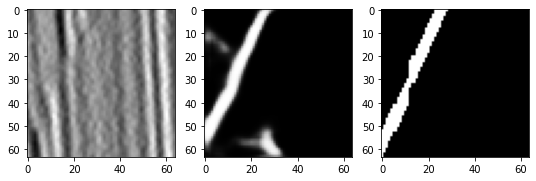

In [11]:
m = UnetModel(in_channels=1, out_channels=1).to(device)
checkpoint = torch.load(os.path.join(RESULTDIR, 'facies.pth'))
m.load_state_dict(checkpoint['model_state_dict'])
m.eval()
with torch.no_grad():
    test_data_tensor = torch.from_numpy(test_data).to(device)
    output = m(test_data_tensor)
    output = torch.sigmoid(output)
    

seis = test_data[0,0,...]
output = output[0,0,...].cpu().data.numpy()
print(output.shape)
k1 = 50
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1,3,1)
p1.imshow(seis[k1,...], aspect=1, cmap=plt.cm.gray)
p2 = plt.subplot(1,3,2)
print(output[k1,...].min())
#p2.imshow(output[k1,...], aspect=1, interpolation='bilinear', vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
p2.imshow(output[k1,...], aspect=1, cmap=plt.cm.gray)
p3 = plt.subplot(1,3,3)
p3.imshow(test_data_y[k1,...], aspect=1, cmap=plt.cm.gray)